# Modeling Protest Trends in South America
This notebook is modeling of the protest data for the South American region. The first section will focus primarily on predicting whether or not a protest received accomodations from the government leadership. This modeling will also look at what the protest outcomes ultimately were. While binary classification was assessed on all state response columns, meaning if accomodation was found in any column in a given row it was counted, multiclass models only assess one column of state responses. This is due to time and data constraints.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import classification as cl

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data/mmALL_073119_csv.csv')
df.head(2)

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15.0,1.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. Great Canadian train journeys into history;...,Canada s railway passenger system was finally...
1,201990002,Canada,20,1990,North America,1,2,25.0,6.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. Autonomy s Cry Revived in Quebec The New Yo...,protestors were only identified as young peop...


In [3]:
print(df.shape)

(16363, 31)


In [4]:
# Data engineering: length of protests
df['years'] = df['endyear'] - df['startyear']
df['months'] = df['endmonth'] - df['startmonth']
df['days'] = df['endday'] - df['startday']
df['total_days'] = df['days'] + (df['months']*30.5) + (df['years']*365)

In [5]:
categorical_columns = ['country', 'year', 'protest', 'protesterviolence',  'participants_category', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4', 'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4','stateresponse5', 'stateresponse6', 'stateresponse7']
numerical_columns = ['startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear', 'years', 'total_days']

id_columns = ['id','sources','notes', 'protesteridentity', 'location']

In [6]:
for column in categorical_columns:
    df[column].fillna('999', inplace=True)
    df[column] = df[column].map(str)
for column in numerical_columns:
    df[column].fillna(999, inplace=True)

In [7]:
sa_df = df[df['region'] == 'South America'].copy()

In [8]:
sa_df = pd.get_dummies(sa_df, columns=['country', 'year', 'protest', 'protesterviolence',  'participants_category'], drop_first=True)

In [9]:
protest_demands = ['protesterdemand1','protesterdemand2', 'protesterdemand3', 'protesterdemand4']
sa_df = pd.get_dummies(sa_df, columns=protest_demands, prefix="dem", drop_first=True)
sa_df_total = cl.dummy_columns(sa_df)
print(sa_df_total.shape)

(1653, 108)


C:\Users\Julia Christensen\Desktop\dsi_home\Group_Project_Boo-Leans\code\classification.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dfs_concat = pd.concat(list_of_dfs, axis = 0).fillna(0)


In [10]:
sa_df_total.head(2)

,id,ccode,region,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,...,dem_land farm issue,.,999,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings
1044,1001990001,100,South America,1,13.0,2.0,1990.0,13.0,2.0,1990.0,...,0,0.0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1045,1001990002,100,South America,2,14.0,2.0,1990.0,15.0,2.0,1990.0,...,0,0.0,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0


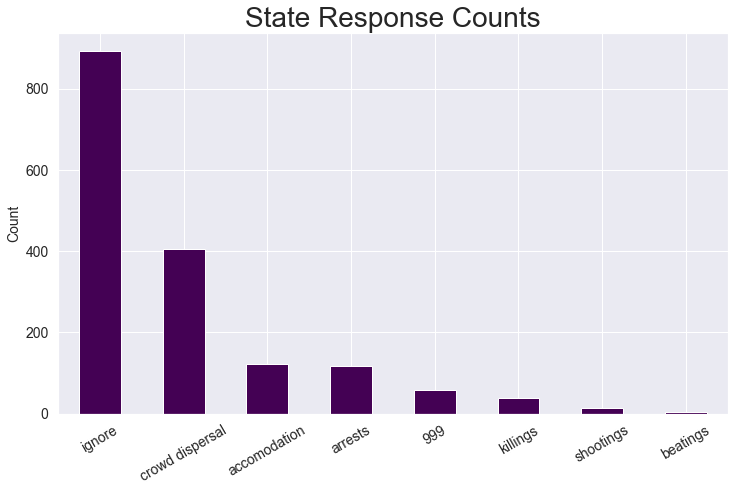

In [17]:
sns.set()
plt.figure(figsize=(12,7))
sa_df['stateresponse1'].value_counts().plot.bar(cmap='viridis', fontsize=14)
plt.xticks(rotation = 30)
plt.ylabel('Count', fontsize=14)
plt.title('State Response Counts', fontsize=28);

In [13]:
sa_df_total['accomodation'] = sa_df_total['accomodation'].map(lambda x: 1 if x>0 else 0)
sa_df_total['accomodation'].value_counts()

0    1474
1     179
Name: accomodation, dtype: int64

In [14]:
sa_df_total['accomodation'].value_counts(normalize=True)

0    0.891712
1    0.108288
Name: accomodation, dtype: float64

In [15]:
drop = ['id', 'ccode', 'region', 'startday',
       'endday', 'endmonth', 'location', 'participants', 'protesteridentity', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes', '.', '999',
       'accomodation', 'arrests', 'beatings', 'crowd dispersal', 'ignore',
       'killings', 'shootings','years','months','days']

X = sa_df_total.drop(columns = drop)
y = sa_df_total['accomodation']
X_train_sc, X_test_sc, y_train, y_test = cl.split_scale(X, y)

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Julia Christensen\Desktop\dsi_home\Group_Project_Boo-Leans\code\classification.py:48: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  X_test_sc = ss.transform(X_test)


## Binary classification of accomodations in state response

In [16]:
logreg_bin = LogisticRegression()
cl.scoring_class(logreg_bin, X_train_sc, y_train, X_test_sc, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) train score Accuracy: 0.9079903147699758
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) test score Accuracy: 0.8743961352657005


C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
cl.con_mets(logreg_bin, X_test_sc, y_test)

Specificity: 0.9728997289972899
Sensitivity: 0.06666666666666667
Precision:   0.23076923076923078


In [18]:
# cl.roc_curve(logreg_bin, 'Logistic Regression ROC Curve', X_test_sc, y_test)

In [19]:
knn_bin = KNeighborsClassifier()
cl.scoring_class(knn_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(knn_bin, X_test_sc, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') train score Accuracy: 0.9063761097659403
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') test score Accuracy: 0.8599033816425121
Specificity: 0.962059620596206
Sensitivity: 0.022222222222222223
Precision:   0.06666666666666667


In [20]:
dt_bin = DecisionTreeClassifier()
cl.scoring_class(dt_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(dt_bin, X_test_sc, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') train score Accuracy: 1.0
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') test score Accuracy: 0.8816425120772947
Specificity: 0.9376693766937669
Sensitivity: 0.4222222222222222
Precision:   0.4523809523809524


In [21]:
rf_bin = RandomForestClassifier()
cl.scoring_class(rf_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(rf_bin, X_test_sc, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) train score Accuracy: 0.9870863599677159
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) test score Accuracy: 0.8888888888888888
Specificity: 0.983739837398374
Sensitivity: 0.1111111111111111
Precisio

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
bdt_bin = BaggingClassifier()
cl.scoring_class(bdt_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(bdt_bin, X_test_sc, y_test)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False) train score Accuracy: 0.9854721549636803
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False) test score Accuracy: 0.8695652173913043
Specificity: 0.94579945799458
Sensitivity: 0.24444444444444444
Precision:   0.3548387096774194


In [23]:
ada_bin = AdaBoostClassifier()
cl.scoring_class(ada_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(ada_bin, X_test_sc, y_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) train score Accuracy: 0.9128329297820823
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) test score Accuracy: 0.8743961352657005
Specificity: 0.948509485094851
Sensitivity: 0.26666666666666666
Precision:   0.3870967741935484


In [24]:
svm_bin = SVC()
cl.scoring_class(svm_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(svm_bin, X_test_sc, y_test)

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) train score Accuracy: 0.9015334947538337
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) test score Accuracy: 0.8913043478260869
Specificity: 1.0
Sensitivity: 0.0
Precision:   nan


C:\Users\Julia Christensen\Desktop\dsi_home\Group_Project_Boo-Leans\code\classification.py:69: RuntimeWarning: invalid value encountered in longlong_scalars
  print(f'Precision:   {tp / (tp + fp)}')


Almost all of the models above are overfit except K Nearest Neighbors and Support Vector Machine. Additionally, None of them have an improvement over baseline in predicting accomodations. Furthermore in most cases the model seems to have similar scores to baseline because the models tend to over predict "no accomodations." 

In [25]:
cl.con_plot(svm_bin, X_test_sc, y_test, 'Support Vector Machine')

In [26]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada_grid_bin = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada_grid_bin.fit(X_train_sc, y_train)
print(ada_grid_bin.best_params_)
print(ada_grid_bin.best_score_)
print(ada_grid_bin.score(X_test_sc, y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.2min finished


{'model__learning_rate': 0.5, 'model__n_estimators': 50, 'pc__n_components': 15}
0.8934624697336562
0.8792270531400966


In [27]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_grid_bin = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_grid_bin.fit(X_train_sc, y_train)
print(svc_grid_bin.best_params_)
print(svc_grid_bin.best_score_)
print(svc_grid_bin.score(X_test_sc, y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "av

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-p

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-p

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-p

{'model__C': 0.01, 'model__degree': 3, 'pc__n_components': 10}
0.8918482647296206
0.8913043478260869


In [74]:
cl.con_mets(svc_grid_bin, X_test_sc, y_test)

Type I error
Specificity: 1.0
Sensitivity: 0.0
Precision:   nan


C:\Users\Julia Christensen\Desktop\dsi_home\Group_Project_Boo-Leans\classification.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
  print(f'Precision:   {tp / (tp + fp)}')


Grid searching over these models improved adaboost slightly but overall the socre is not improved over baseline.

## Multiclass classification of state response

In [79]:
y_m = sa_df['stateresponse1']
y_m.value_counts()

ignore             892
crowd dispersal    405
accomodation       123
arrests            118
999                 58
killings            39
shootings           14
beatings             4
Name: stateresponse1, dtype: int64

In [80]:
#Combine the 3 most violent categories as there seems to be little difference
y_m = y_m.map(str)
y_m = y_m.map({'ignore': 0, 'crowd dispersal': 1, 'accomodation': 2, 'arrests': 3, 'killings': 4, 'shootings': 4, 'beatings': 4, '999': 999})
y_m.value_counts()

0      892
1      405
2      123
3      118
999     58
4       57
Name: stateresponse1, dtype: int64

In [81]:
X_train_sc, X_test_sc, y_train_m, y_test_m = cl.split_scale(X, y_m)

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Julia Christensen\Desktop\dsi_home\Group_Project_Boo-Leans\classification.py:48: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  X_test_sc = ss.transform(X_test)


In [83]:
logreg_m = LogisticRegression()
cl.scoring_class(logreg_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) train score R2: 0.7062146892655368
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) test score Rs: 0.6594202898550725


In [85]:
knn_m = KNeighborsClassifier()
cl.scoring_class(knn_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') train score R2: 0.7021791767554479
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') test score Rs: 0.5603864734299517


In [86]:
svm_m = SVC()
cl.scoring_class(svm_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) train score R2: 0.7288135593220338
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) test score Rs: 0.6328502415458938


In [87]:
dt_m = DecisionTreeClassifier()
cl.scoring_class(dt_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') train score R2: 1.0
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') test score Rs: 0.5628019323671497


In [88]:
bdt_m = BaggingClassifier()
cl.scoring_class(bdt_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False) train score R2: 0.9717514124293786
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False) test score Rs: 0.6280193236714976


In [89]:
rf_m = RandomForestClassifier()
cl.scoring_class(rf_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) train score R2: 0.9757869249394673
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) test score Rs: 0.6231884057971014


C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [90]:
ada_m = AdaBoostClassifier()
cl.scoring_class(ada_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) train score R2: 0.4794188861985472
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) test score Rs: 0.47342995169082125


While many of these models are much worse that the binary classification however Logistic regression was able to get a better accuracy than baseline and many of the others show some promise given some regulation.

In [91]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_grid_bin = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_grid_bin.fit(X_train_sc, y_train_m)
print(svc_grid_bin.best_params_)
print(svc_grid_bin.best_score_)
print(svc_grid_bin.score(X_test_sc, y_test_m))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "av

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-p

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-p

C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Julia Christensen\anaconda\lib\site-p

{'model__C': 0.05, 'model__degree': 3, 'pc__n_components': 10}
0.5520581113801453
0.5579710144927537
